### <left> High-Dimensional Deep Learning - 5A
## <center>*Mini-project n° 2 – Conditional VAEs*</center>
### <center>2024-2025</center>
<div style="text-align: right;">
    <b>Project 2/4</b><br>
<div style="text-align: left;">
<b>Noms :</b> Maïmouna Gadji, Phuc-Luan Nguyen, Maddie Perez et Julia Soufflet<br>

### Objectif : 

L'objectif de ce projet est de définir et d'entraîner un auto-encodeur variationnel conditionnel (CVAE)

# I - Introduction aux VAE et CVAE

Une des premières étapes consiste à définir les CVAE et expliquer leurs différences avec les VAE, en appuyant nos explications sur des ressources fiables.

Voici quelques liens que nous avons trouvé utiles : 

https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95

https://medium.com/@sofeikov/implementing-conditional-variational-auto-encoders-cvae-from-scratch-29fcbb8cb08f

https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html


## I.1 - Rappel sur les VAE 
Les **Variational Autoencoders (VAE)** sont un type de réseau d'autoencodeur probabiliste, capable de générer des nouvelles données en apprenant une représentation latente continue des données d'entrée. Le VAE se compose de deux parties principales :

- **Encodeur** : Il mappe l'entrée \( x \) vers une distribution latente, en produisant des paramètres (moyenne et écart-type) d'une distribution gaussienne dans un espace latent continu.
- **Décodeur** : À partir d'un point \( z \) tiré de cette distribution latente, il reconstruit une version approximative de l'entrée, notée \( x' \).

Une particularité des VAE réside dans leur **prior distribution** (ou distribution a priori) : il s'agit de la distribution souhaitée pour l'espace latent. Généralement, cette distribution a priori est une gaussienne standard $ \mathcal{N}(0, 1) $, ce qui impose une structure particulière sur l'espace latent. En encourageant l'espace latent à suivre cette distribution gaussienne, le VAE est capable de générer des nouvelles données en tirant des échantillons aléatoires de l'espace latent et en les passant dans le décodeur.


Le processus de génération d'une nouvelle donnée implique donc de sélectionner aléatoirement un vecteur latent \( z \) selon la distribution apprise par l'encodeur. Ensuite, ce \( z \) est passé dans le décodeur pour obtenir une reconstruction. Cela permet de créer des nouvelles instances qui suivent les caractéristiques générales des données d'entraînement.

Le VAE utilise une fonction de perte composée de deux termes principaux :
1. **Reconstruction loss** : Mesure la différence entre l'entrée d'origine \( x \) et la reconstruction \( x' \), permettant de minimiser la perte d'information.
2. **KL Divergence** : Régularise la distribution latente pour qu'elle suive une distribution normale standard $ \mathcal{N}(0, 1) $, assurant la continuité et la généralisation dans l'espace latent.


**Problème des VAE :** Bien que les VAE soient capables de générer de nouvelles instances, ils ne permettent pas d’imposer des conditions spécifiques (par exemple, générer une image d'une catégorie donnée comme une chaussure ou un pull). C'est cela qui nous amène à étudier les CVAE.

## I.2 - Définition CVAE

Les **Conditional Variational Autoencoders (CVAE)** représentent une extension des VAE qui permettent de conditionner la génération sur une information supplémentaire, comme une classe ou un label. Le CVAE ajoute ainsi une contrainte à la génération de données, ce qui permet de contrôler le type de données générées.

## I.3 - Différences entre VAE et CVAE

Dans un VAE, pour générer une nouvelle observation \( x \), on sélectionne un \( z \) à partir de la distribution latente, puis le décodeur génère l'image correspondante \( x \). La classe de l’image générée est donc imprévisible. 

Dans les CVAE, la **distribution a priori** dépend également du label \( y \). En d'autres termes, pour chaque classe \( y \), on a une distribution a priori conditionnelle \( p(z | y) \). Cette approche permet de réguler l'espace latent en fonction des classes, rendant possible la génération d'exemples d'une classe spécifique. 

Avec un CVAE, la génération devient conditionnelle. Concrètement :
- L'encodeur reçoit en entrée l'image \( x \) ainsi que son label \( y \), et génère une distribution latente \( p(z | y) \).
- Lors de la génération, on choisit d'abord le label souhaité \( y \), puis on tire un vecteur latent \( z \) selon la distribution conditionnelle \( p(z | y) \).
- Enfin, le décodeur utilise ce \( z \) et le label \( y \) pour générer l'image conditionnée \( x' \), suivant la distribution \( p(x | z, y) \).

Cette architecture permet de générer des données spécifiques à une catégorie choisie, ce qui est particulièrement utile dans des applications où le contrôle sur le type de données générées est nécessaire (comme demandé dans le projet avec les catégories du dataset Fashion-MNIST, pour générer des images selon des labels précis).



# II - Entraîner un CVAE sur Fashion-MNIST 
Dans cette section, nous allons présenter le choix de l'architecture, des hyperparamètres et de la fonction de perte utilisés pour entraîner un **Conditional Variational Autoencoder (CVAE)** sur le dataset Fashion-MNIST. Nous justifions également ces choix à chaque étape et listons les ressources qui nous ont aidés à les faire.

## II.1 - Chargement des données

Pour ce projet, nous utilisons le dataset **Fashion-MNIST**, composé d'images en niveaux de gris de vêtements classés en 10 catégories (T-shirt/top, Pantalon, Pull, etc.). Le chargement des données est effectué via `torchvision.datasets`.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

fashion_mnist_labels = [
    "T-shirt/top",
    "Pants",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


## II.1 - Visualisation des données

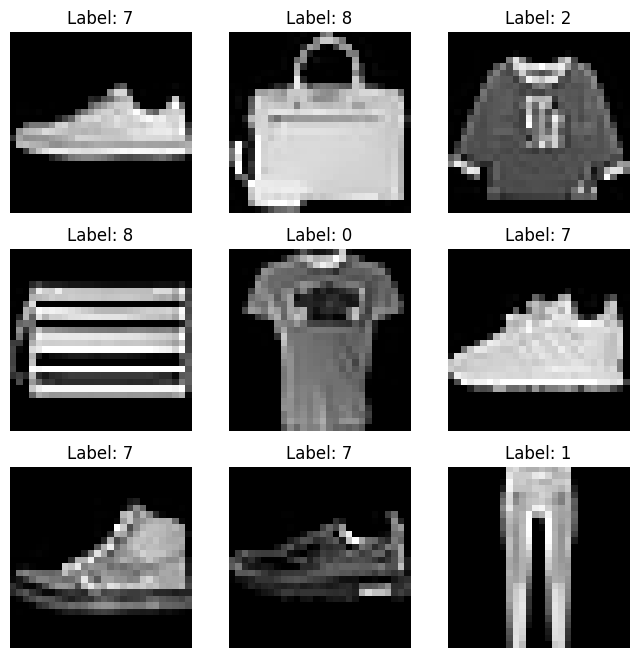

[0 1 2 3 4 5 6 7 8 9]
10


In [3]:
# Plot 9 random images de fashion MNIST
def plot_images(img_dataset):
    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)
print(np.unique(train_dataset.targets[:]))
num_classes = np.size(np.unique(train_dataset.targets[:]))
print(num_classes)

## II.3 - Choix de l'Architecture

L'architecture du **Conditional Variational Autoencoder (CVAE)** pour ce projet repose sur un modèle convolutif permettant de capturer les caractéristiques visuelles des images Fashion-MNIST. Voici les choix architecturaux que nous avons faits et leurs justifications :

- **Encodeur** : 
    - L'encodeur utilise des couches de convolution pour extraire les caractéristiques des images. Les couches convolutionnelles réduisent progressivement la taille des images d'entrée tout en augmentant le nombre de canaux de sortie, permettant au modèle de capturer des détails de plus en plus complexes.
    - Nous ajoutons des couches de normalisation (**BatchNorm**) et des fonctions d'activation **ReLU** pour stabiliser l'entraînement et introduire de la non-linéarité.
    - Les convolutions utilisent des tailles de kernel de 3x3 et 4x4 pour capter des détails plus fins dans les images.
    - Le label de la classe \( y \) est intégré en concaténant \( y \) avec le vecteur latente en sortie des convolutions avant les couches entièrement connectées (`fc_mu` et `fc_logvar`).

- **Espace latent** :
    - Le modèle génère un vecteur latent \( z \) à partir de la **moyenne** (`mu`) et de la **log-variance** (`logvar`) des données encodées. Ce vecteur est ensuite concaténé avec le label \( y \) pour le passage dans le décodeur.

- **Décodeur** :
    - Le décodeur utilise des **convolutions transposées** pour reconstruire les images d'entrée. Ces couches permettent d'augmenter la taille des cartes de caractéristiques tout en réduisant le nombre de canaux, inversant ainsi le processus de l'encodeur.
    - La dernière couche applique une activation **Sigmoid** pour s'assurer que les sorties sont entre 0 et 1, en cohérence avec les valeurs des pixels des images en niveaux de gris de Fashion-MNIST.
    
Cette architecture permet de conditionner efficacement le processus de génération d'images sur les labels de classe, tout en capturant des détails fins grâce aux convolutions.


In [4]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4) + kernel_size = 3 : capturer des détails plus fins
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4+ num_classes, latent_dim)  #pour forcer à avor des valeurs positives, on prend le log de var et non pas var
        self.fc_decode = nn.Linear(latent_dim+ num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    #TO DO (concatenation de x et y)
    def encode(self, x, y):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat((x,y), dim = 1) # Concatenate and flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
     #TO DO (concatenation de z et y)
    def decode(self, z, y):
        z = torch.cat((z,y), dim = 1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x
        
    #TO DO (ajout de y en argument)
    def forward(self, x, y):
        mu, logvar = self.encode(x,y)
        z = self.sample(mu, logvar)
        return self.decode(z,y), mu, logvar

$$
\text{Sortie} = \left\lfloor \frac{\text{Entrée} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

## II.4 - Choix de la Fonction de Perte

Les CVAE utilisent une fonction de perte similaire aux VAE avec :
1. Une **reconstruction loss** qui évalue la qualité de la reconstruction en comparant \( x \) et \( x' \). Calculée avec la Binary Cross Entropy (`BCE`) entre l'image originale et l'image reconstruite, pour capturer les détails en niveaux de gris. 
2. Une **KL divergence** qui régularise la distribution latente conditionnelle \( p(z | y) \) pour la rapprocher de la distribution a priori \( \mathcal{N}(0, 1) \).

L'hyperparamètre `beta` régule l'importance de la KL divergence par rapport à la reconstruction.

La pondération de la KL divergence est cruciale pour assurer un bon équilibre entre la diversité des données générées et la précision des reconstructions. Ajuster ces termes dans la loss function est essentiel pour atteindre une bonne performance du modèle.
https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html

(aller voir cours VAE slide 35)

In [45]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') #terme de reconstruction (noir et blanc contraste sinon mse)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #envoyer sur une loi normale
    return BCE + beta * KLD

## II.5 - Choix des Hyperparamètres et premier entraînement

Dans cette section, nous définissons les **hyperparamètres** et le processus d’entraînement de notre modèle sur le dataset Fashion-MNIST. Voici les détails de chaque paramètre et leur rôle dans l'apprentissage du modèle.

- **`batch_size`** : Nombre d'exemples utilisés dans chaque batch pour l'entraînement. Ici, `batch_size = 128`, ce qui offre un bon compromis entre efficacité de calcul et stabilité des gradients.
  
- **`latent_dim`** : Dimension de l’espace latent du modèle. Un espace latent de `latent_dim = 20` permet de capturer une représentation suffisamment riche des caractéristiques des images tout en évitant un surdimensionnement, qui pourrait entraîner des reconstructions de mauvaise qualité.

- **`learning_rate`** : Taux d'apprentissage pour l'optimisation du modèle. Une valeur de `1e-3` est souvent un bon point de départ pour stabiliser les mises à jour des poids. Il faudra cependant faire attention à éviter les oscillations de la loss lorsqu'on l'ajustera.

- **`epochs`** : Nombre d'epochs (cycles complets sur l’ensemble des données d’entraînement). En fixant `epochs = 30`, nous espérons que le modèle ait suffisamment d’itérations pour apprendre les représentations latentes tout en minimisant le surapprentissage. On a pris 30 pour commencer, pour permettre une convergence suffisante du modèle tout en ne prenant pas trop de temps. On pourra toujours ajuster ce nombre plus tard.

- **`beta`** : Coefficient pour la pondération de la **KL Divergence** dans la fonction de perte. Ici, `beta = 1`, ce qui équilibre les termes de reconstruction et de régularisation. Ajuster ce paramètre pourrait améliorer l’entraînement en réduisant la perte de reconstruction sans trop restreindre l’espace latent.

Pour plus d’informations sur le choix des hyperparamètres : https://www.linkedin.com/advice/1/how-can-you-choose-right-hyperparameters-qtifc .

In [18]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
#pour mettre à jour les paramètres du modèle avec un taux d’apprentissage défini, on utilise l'optimiseur Adam
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 266.4898
Epoch 2, Training loss: 245.5656
Epoch 3, Training loss: 242.5237
Epoch 4, Training loss: 240.7278
Epoch 5, Training loss: 239.4895
Epoch 6, Training loss: 238.5932
Epoch 7, Training loss: 237.9897
Epoch 8, Training loss: 237.3814
Epoch 9, Training loss: 236.9877
Epoch 10, Training loss: 236.6283
Epoch 11, Training loss: 236.2662
Epoch 12, Training loss: 235.9396
Epoch 13, Training loss: 235.7433
Epoch 14, Training loss: 235.4748
Epoch 15, Training loss: 235.2662
Epoch 16, Training loss: 235.0464
Epoch 17, Training loss: 234.8791
Epoch 18, Training loss: 234.7352
Epoch 19, Training loss: 234.5555
Epoch 20, Training loss: 234.4851
Epoch 21, Training loss: 234.3123
Epoch 22, Training loss: 234.2193
Epoch 23, Training loss: 234.1213
Epoch 24, Training loss: 234.0262
Epoch 25, Training loss: 233.8708
Epoch 26, Training loss: 233.8392
Epoch 27, Training loss: 233.7560
Epoch 28, Training loss: 233.6497
Epoch 29, Training loss: 233.6318
Epoch 30, Training loss

**Interprétation des Résultats :**

On peut voir une diminution progressive de la perte à chaque époque, ce qui indique que le modèle parvient à optimiser sa reconstruction tout en régularisant l’espace latent.

- **Stabilisation de la perte** : À partir de l’époque 20, la perte tend à se stabiliser autour de 233, ce qui pourrait indiquer une convergence de l’entraînement. Cela signifie que le modèle a atteint une bonne balance entre précision de la reconstruction et régularisation, et il peut générer des images plausibles à partir de l’espace latent conditionnel.

- **Tendance de la courbe de perte** : La diminution constante de la perte au fil des époques montre que l’apprentissage progresse sans oscillations majeures, suggérant que le taux d’apprentissage et la pondération de la KL Divergence (beta) sont bien choisis. Cependant, un affinement de beta pourrait améliorer légèrement la qualité de la reconstruction sans sacrifier la diversité des données générées.

## II.6 - Différents trials

### Batch_size*2

In [20]:
# Hyperparameters
batch_size = 256
latent_dim = 20
learning_rate = 1e-2
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 293.6568
Epoch 2, Training loss: 248.3198
Epoch 3, Training loss: 244.3719
Epoch 4, Training loss: 242.2145
Epoch 5, Training loss: 240.5879
Epoch 6, Training loss: 239.4949
Epoch 7, Training loss: 238.5714
Epoch 8, Training loss: 238.0624
Epoch 9, Training loss: 237.6604
Epoch 10, Training loss: 237.3472
Epoch 11, Training loss: 236.9679
Epoch 12, Training loss: 236.7405
Epoch 13, Training loss: 236.6933
Epoch 14, Training loss: 236.3066
Epoch 15, Training loss: 236.1446
Epoch 16, Training loss: 235.9132
Epoch 17, Training loss: 235.7362
Epoch 18, Training loss: 235.6216
Epoch 19, Training loss: 235.3932
Epoch 20, Training loss: 235.3398
Epoch 21, Training loss: 235.2166
Epoch 22, Training loss: 235.1339
Epoch 23, Training loss: 234.8978
Epoch 24, Training loss: 234.8460
Epoch 25, Training loss: 234.7261
Epoch 26, Training loss: 234.7016
Epoch 27, Training loss: 234.5732
Epoch 28, Training loss: 234.4270
Epoch 29, Training loss: 234.3251
Epoch 30, Training loss

### lr=1e-2

In [46]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-2
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
cvae = CVAE(latent_dim=latent_dim)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 328.7377
Epoch 2, Training loss: 251.4331
Epoch 3, Training loss: 247.3715
Epoch 4, Training loss: 244.6901
Epoch 5, Training loss: 242.9709
Epoch 6, Training loss: 242.2045
Epoch 7, Training loss: 240.6815
Epoch 8, Training loss: 239.8278
Epoch 9, Training loss: 239.1078
Epoch 10, Training loss: 238.2203
Epoch 11, Training loss: 237.7245
Epoch 12, Training loss: 237.3289
Epoch 13, Training loss: 236.9694
Epoch 14, Training loss: 236.6784
Epoch 15, Training loss: 236.4993
Epoch 16, Training loss: 236.3096
Epoch 17, Training loss: 236.0507
Epoch 18, Training loss: 235.8945
Epoch 19, Training loss: 235.7127
Epoch 20, Training loss: 235.6220
Epoch 21, Training loss: 235.4970
Epoch 22, Training loss: 235.3686
Epoch 23, Training loss: 235.2051
Epoch 24, Training loss: 235.1583
Epoch 25, Training loss: 234.9860
Epoch 26, Training loss: 234.9092
Epoch 27, Training loss: 234.8307
Epoch 28, Training loss: 234.6693
Epoch 29, Training loss: 234.6470
Epoch 30, Training loss

# III - Visualiser les résultats

Original labels shape: torch.Size([128])
One-hot labels shape: torch.Size([128, 10])


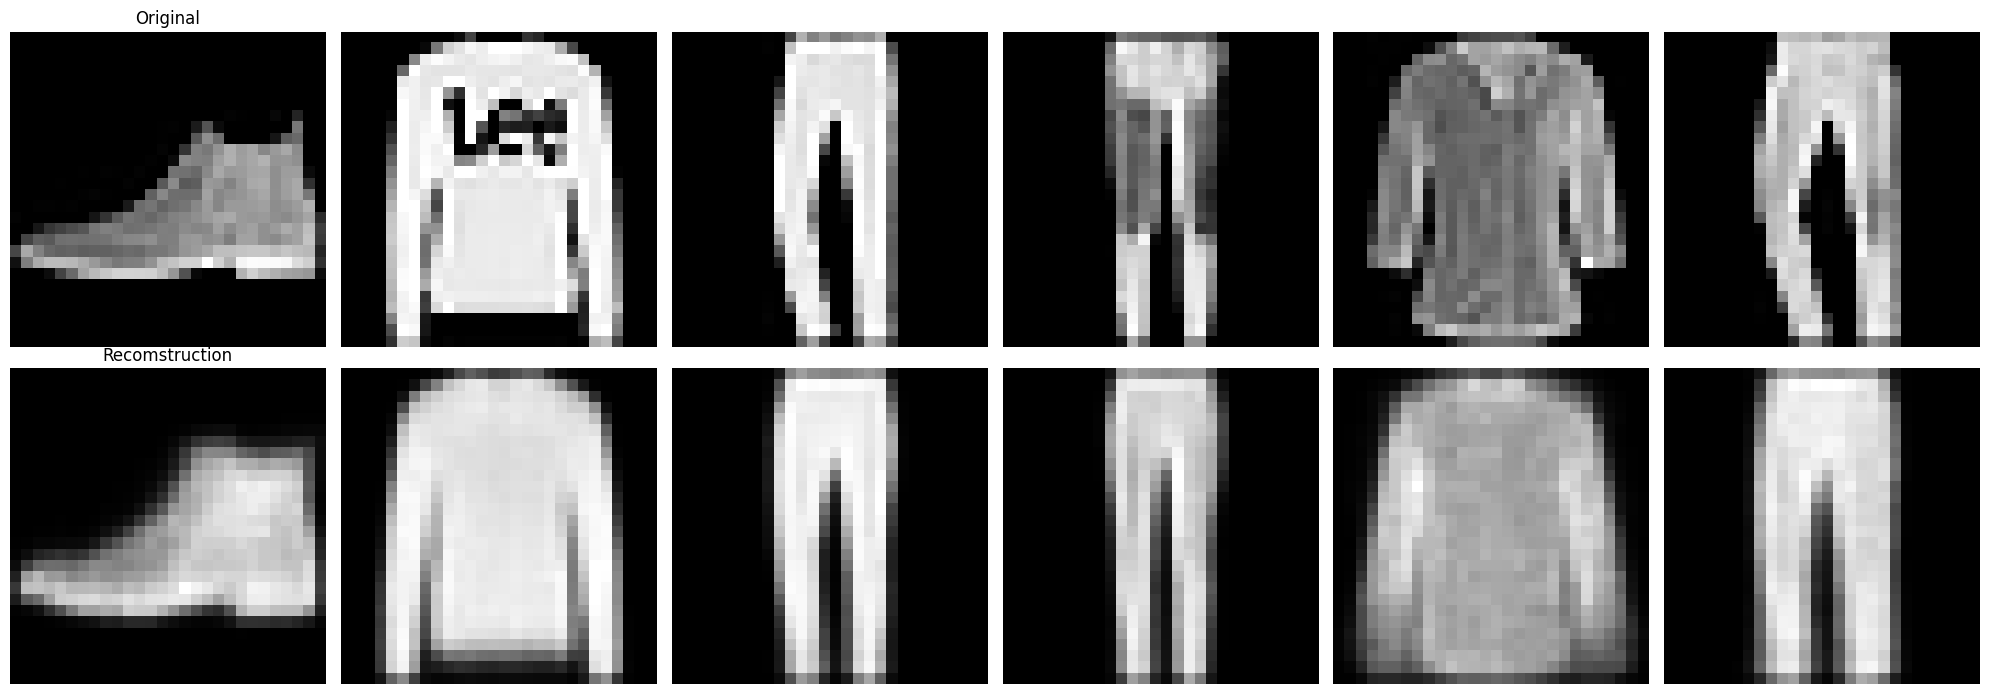

Ankle boot
Pullover
Pants
Pants
Shirt
Pants


In [81]:
# TODO: Define or import the image_comparison function
from utils import image_comparison 
# Select a batch of images from the test dataset
random_images = next(iter(test_loader))
# Vérifier la forme des étiquettes
labels = random_images[1]
print(f"Original labels shape: {labels.shape}")  # Devrait être (batch_size,)

# Convertir les étiquettes en one-hot si ce n'est pas déjà fait
if len(labels.shape) == 1:  # Vérifie si c'est un vecteur
    labels_one_hot = F.one_hot(labels, num_classes=10)  # Convertir en one-hot
else:
    labels_one_hot = labels  # Si déjà en one-hot

print(f"One-hot labels shape: {labels_one_hot.shape}")  # Devrait être (batch_size, 10)

# Passer les données au modèle
recons, _, _ = cvae(random_images[0].to(device), labels_one_hot.to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

    
labels = labels[:6]
for i in labels:
    print(fashion_mnist_labels[i])
labels_one_hot = labels_one_hot[:10,:]

loss ok en vrai car les images sont plutôt bien reconstruites (5/6 sont largement distinguables)

# IV - Générer 5 samples for each class of the Fashion-MNIST dataset using the CVAE.

Ankle boot
Pullover
Pants
Pants
Shirt


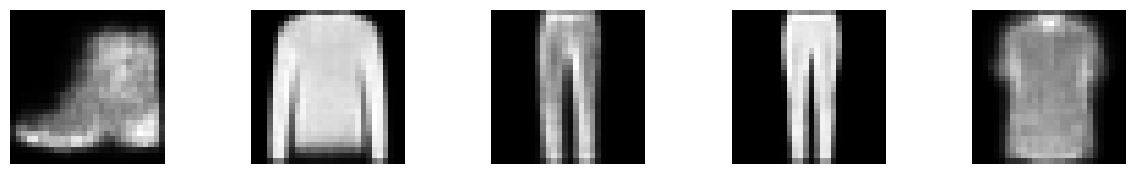

In [79]:
def generate_sample(num_samples=5):
    #selection de labels
    random_images = next(iter(test_loader))
    labels = random_images[1]
    labels_one_hot = F.one_hot(labels, num_classes=10)  # Convertir en one-hot

    labels = labels[:num_samples]
    labels_one_hot = labels_one_hot[:num_samples,:]
        
    cvae.eval()
    with torch.no_grad():
        # TODO: Sample random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors
        y = labels_one_hot.to(device)

        for i in labels:
            print(fashion_mnist_labels[i])
         
        samples = cvae.decode(z,y) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

**attention ici on a généré que 5 samples, pas 5 samples par classe**

In [ ]:
#à tester car je n'ai pas pu le faire sur mon ordi perso
def generate_samples_per_class(num_samples=5):
    """
    Génère `num_samples` images pour chaque classe de Fashion-MNIST.
    """
    cvae.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(10, num_samples, figsize=(15, 10))
        
        # Pour chaque classe (0 à 9 correspondant aux catégories de vêtements)
        for class_idx in range(10):
            # Crée un label one-hot pour la classe en cours
            y = torch.zeros((num_samples, 10), device=device)
            y[:, class_idx] = 1  # Encode la classe actuelle
            
            # Échantillonne aléatoirement `num_samples` vecteurs latents
            z = torch.randn(num_samples, latent_dim).to(device)
            
            # Décode les vecteurs latents conditionnés sur le label de la classe
            samples = cvae.decode(z, y)
            samples = samples.cpu().view(num_samples, 1, 28, 28)
            
            # Affiche les échantillons générés pour cette classe
            for i in range(num_samples):
                axs[class_idx, i].imshow(samples[i].squeeze(0), cmap='gray')
                axs[class_idx, i].axis('off')
                if i == 0:
                    axs[class_idx, i].set_title(fashion_mnist_labels[class_idx], fontsize=10)
    
    plt.tight_layout()
    plt.show()

generate_samples_per_class()


## Plot different visualizations for the results: the curves of the different terms in the loss functions, the learnt latent space...

In [22]:
# Rewrite loss function to return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 271.9789, BCE: 267.0634, KLD: 4.9155
Epoch 2: Average Loss: 257.5689, BCE: 252.5243, KLD: 5.0446
Epoch 3: Average Loss: 256.0956, BCE: 251.0735, KLD: 5.0221
Epoch 4: Average Loss: 255.0768, BCE: 250.0975, KLD: 4.9793
Epoch 5: Average Loss: 254.2529, BCE: 249.2872, KLD: 4.9657
Epoch 6: Average Loss: 254.0179, BCE: 249.0617, KLD: 4.9562
Epoch 7: Average Loss: 253.5340, BCE: 248.6051, KLD: 4.9289
Epoch 8: Average Loss: 253.1828, BCE: 248.2547, KLD: 4.9281
Epoch 9: Average Loss: 252.8086, BCE: 247.9021, KLD: 4.9065
Epoch 10: Average Loss: 252.6006, BCE: 247.7089, KLD: 4.8916


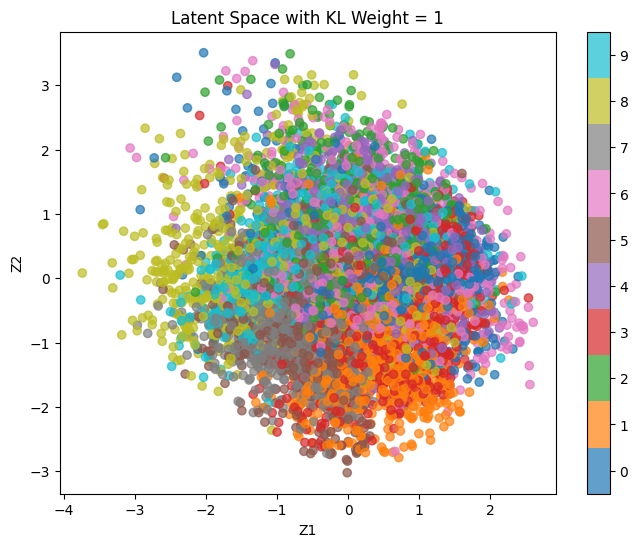

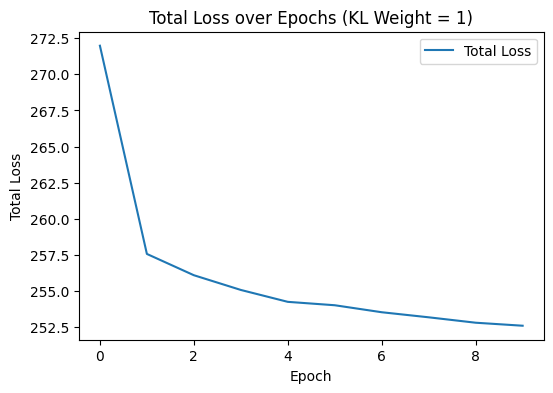

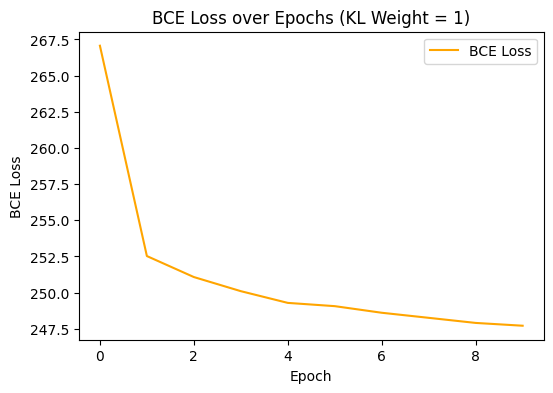

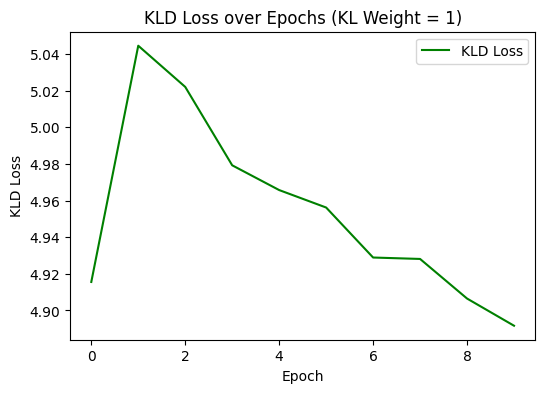


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 306.4709, BCE: 291.8265, KLD: 1.4644
Epoch 2: Average Loss: 283.7416, BCE: 267.5049, KLD: 1.6237
Epoch 3: Average Loss: 281.7023, BCE: 264.8990, KLD: 1.6803
Epoch 4: Average Loss: 280.5592, BCE: 263.5281, KLD: 1.7031
Epoch 5: Average Loss: 279.7297, BCE: 262.4654, KLD: 1.7264
Epoch 6: Average Loss: 279.3381, BCE: 261.9127, KLD: 1.7425
Epoch 7: Average Loss: 278.8531, BCE: 261.3592, KLD: 1.7494
Epoch 8: Average Loss: 278.5836, BCE: 260.9713, KLD: 1.7612
Epoch 9: Average Loss: 278.3514, BCE: 260.5814, KLD: 1.7770
Epoch 10: Average Loss: 278.0441, BCE: 260.2471, KLD: 1.7797


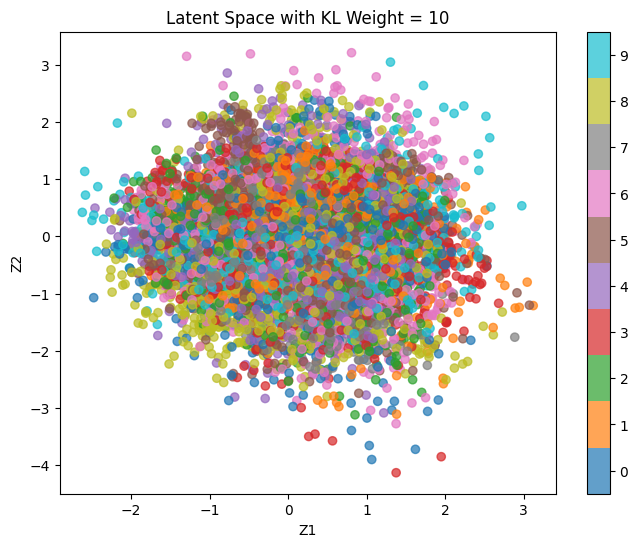

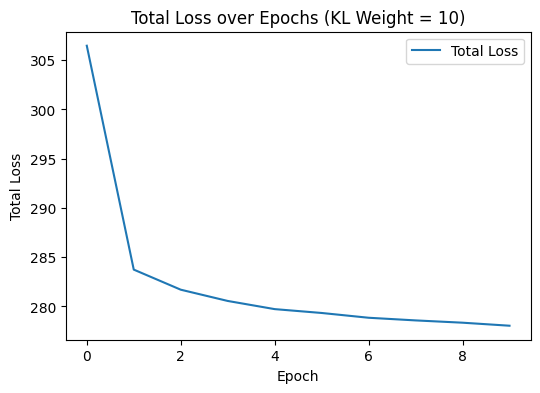

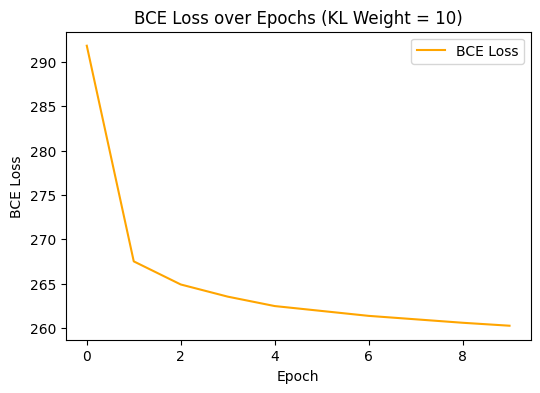

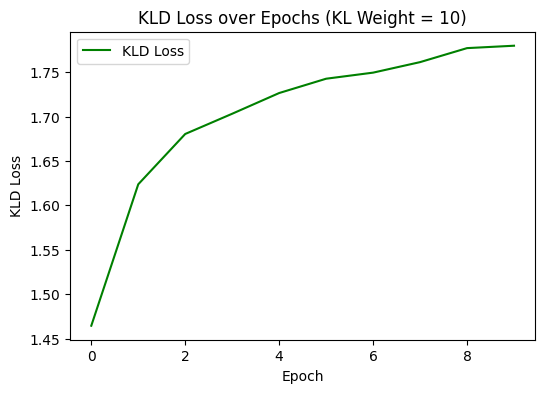


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 319.1322, BCE: 316.7302, KLD: 0.0240
Epoch 2: Average Loss: 308.0681, BCE: 307.9325, KLD: 0.0014
Epoch 3: Average Loss: 307.8075, BCE: 307.7026, KLD: 0.0010
Epoch 4: Average Loss: 307.6827, BCE: 307.5915, KLD: 0.0009
Epoch 5: Average Loss: 307.6329, BCE: 307.5358, KLD: 0.0010
Epoch 6: Average Loss: 307.5613, BCE: 307.4738, KLD: 0.0009
Epoch 7: Average Loss: 307.5629, BCE: 307.4738, KLD: 0.0009
Epoch 8: Average Loss: 307.5181, BCE: 307.4381, KLD: 0.0008
Epoch 9: Average Loss: 307.4975, BCE: 307.4090, KLD: 0.0009
Epoch 10: Average Loss: 307.4588, BCE: 307.3916, KLD: 0.0007


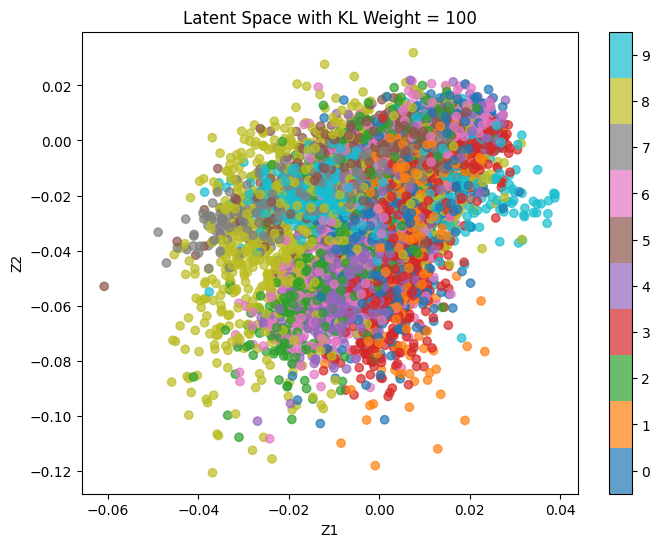

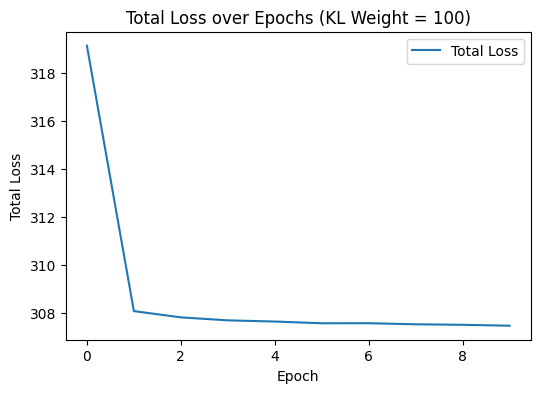

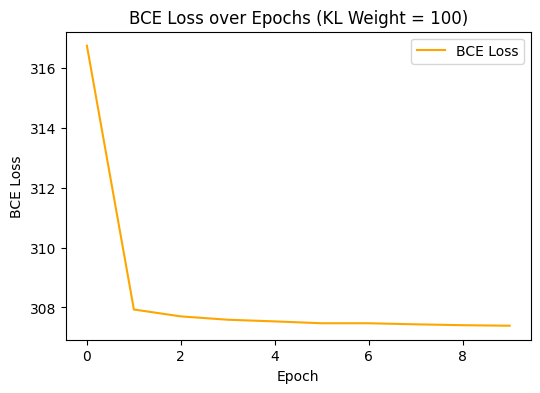

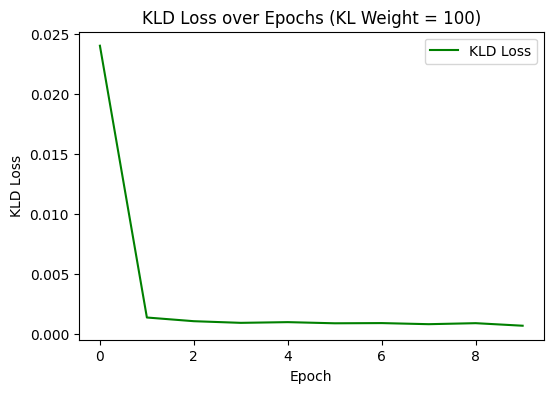

In [43]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = CVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []

    av_bce_l = []
    av_kld_l = []
    av_loss_l = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            labels = F.one_hot(labels, num_classes=10).to(device)
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
            
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)

        av_bce_l.append(average_bce)
        av_kld_l.append(average_kld)
        av_loss_l.append(average_loss)
            
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Plot latent space
    plot_latent_space(model, kl_weight)

    plt.figure(figsize=(6, 4))
    plt.plot(av_loss_l, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title(f'Total Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(av_bce_l, label='BCE Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.title(f'BCE Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(av_kld_l, label='KLD Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('KLD Loss')
    plt.title(f'KLD Loss over Epochs (KL Weight = {kl_weight})')
    plt.legend()
    plt.show()

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

        data, labels = next(iter(test_loader))
        labels_one_hot = F.one_hot(labels, num_classes=10).to(device)

        data = data.to(device)
        mu, logvar = model.encode(x=data, y=labels_one_hot)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

Yes, your results for the CVAE appear to be coherent with what we would expect when varying the KL weight beta:

Low  β=1:
        The latent space is quite spread out, and we can see a loose clustering pattern for different classes. This is because, with a lower ββ, the reconstruction term (BCE) is more dominant, encouraging the CVAE to retain more detail for each data point, which leads to more separation between classes.
        The clusters are distinguishable, though they overlap significantly due to the relatively weak regularization.

Moderate β=10:
        With an intermediate value of ββ, the latent space clusters start to become more compact, and the spread decreases.
        The balance between the reconstruction term and the KL divergence results in clusters that are closer together but still have visible distinctions. The CVAE now puts more emphasis on the regularization term, pulling the latent space closer to a Gaussian shape, while still retaining some class-specific structures due to the conditioning.

High β=100β=100:
        With a high ββ, the latent space becomes tightly packed around a central Gaussian-like distribution. The clusters overlap significantly, and it’s harder to distinguish classes from each other.
        The dominant KL term encourages the latent representations to be close to the prior distribution, which causes the classes to lose distinct separation. This effect is typical in both VAEs and CVAEs, though in CVAEs, conditioning usually helps preserve some structure. Here, the structure is nearly lost due to the strong influence of the KL divergence.


The results align with expectations: as ββ increases, the latent space becomes more Gaussian and compact, with reduced distinction between classes. In CVAEs, the conditioning helps retain some class separation even at higher ββ values, but when ββ is very high, the KL regularization effect dominates, leading to a more overlapped latent space.

Overall, these results are consistent with the behavior of CVAEs and reflect a reasonable progression of latent space structure as ββ changes.

For a Conditional Variational Autoencoder (CVAE), the effect of the KL weight ββ on the latent space is similar in principle but with some differences due to the conditioning information:

Effect of KL Weight ββ on Latent Space:
        As in a standard VAE, increasing ββ in a CVAE will encourage the latent space to align more closely with a Gaussian prior, resulting in a more compact distribution around the origin.
        However, since a CVAE conditions on an additional variable (e.g., class labels), each class tends to occupy a distinct area within the latent space even as ββ increases. This conditioning information helps separate the clusters, so they may remain more distinct compared to an ordinary VAE at higher ββ values.
        At low ββ, the CVAE latent space is more spread out, with clear distinctions between classes because the reconstruction term dominates. As ββ increases, the clusters will move closer to the prior distribution’s shape but may still retain separation due to the conditioning.

Explanation:
        In a CVAE, the latent space not only needs to approximate a Gaussian but also to respect the conditioning information. The reconstruction term (BCE) helps the model retain detailed information about each class, while the KL divergence term (weighted by ββ) regularizes the distribution to resemble a Gaussian.
        The class labels encourage the latent space to remain structured by class, even with higher ββ values, because the CVAE learns to differentiate classes in the latent space.
        As ββ increases, the clusters in a CVAE may still be closer together but are likely to remain more distinct compared to a standard VAE, since the model needs to generate data conditioned on specific labels.

In summary, while the overall impact of ββ is similar, the conditional structure of a CVAE allows for more preserved separation between classes in the latent space, even at higher ββ values.